This is starter code for homework 6.  Most of the code won't run as is.  You need to complete the missing parts of the functions.

In [1]:
import numpy as np
import sklearn as sk
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
import pandas as pd

In [2]:
matplotlib.rcParams['figure.figsize'] = (12,8)

# Problem 1

## Part a

Fill in the missing parts of the classes below, marked with TODO.

In [3]:
#This class represents your loss function, (1/2) sum((y-yhat)^2).
#Note: we are including a 1/2, which we don't always do, so that your derivatives will be particularly nice.
#The functions should operate on vectors y and yhat
class Loss(object):
    def __init__(self):
        #These fields will store the last seen y and yhat
        #The stored values will be used by backward() to compute the gradient of this function
        #at the last evaluated point
        self.last_y = 0
        self.last_yhat = 0
    
    #This function returns the value of the loss
    def forward(self, y, yhat):
        #Store the new values for use in the gradient
        self.last_y = y
        self.last_yhat = yhat
        
        ## You need to fill this in to return the value of the loss at y and yhat
        return 0.5*np.linalg.norm(y-yhat)**2
    
    # This function returns the gradient of the loss: y - yhat
    # Important: This must be an (n,1) matrix.  Not (n,). 
    def backward(self):
        #Grab the length of y for shape checking
        n = len(self.last_y)
        
        # TODO: You need to compute the gradient of the loss with respect to yhat: -(y-yhat).
        return_value = -(self.last_y-self.last_yhat).reshape((n,1))
        
        #Let's check the shape of the return value to keep you sane
        assert return_value.shape == (n,1), "Loss backward returns wrong shape"
        return return_value
    
#This class represents your linear function, beta -> X\beta.  Should work for an n by p matrix X.
class LinearFunction(object):
    #Linear function is initialized with a dimension p, and an optional starting value beta
    def __init__(self, p, beta=None):
        self.p = p
        if beta is None:
            self.beta = np.zeros((p,1))
        else:
            #We make sure that beta starts with the right shape, even if you send in the wrong shape
            self.beta = beta.reshape((p,1))
        #Store the last X seen by this function, initialize to 0
        self.last_X = 0
    
    #This function returns the value of the linear function at an X and the current beta: X*beta
    def forward(self, X):
        #Record the new X for use later in the gradient
        n,p = X.shape
        self.last_X = X
        
        # TODO: You need to compute the value of your linear function: X*beta (matrix multiplied)
        # Make sure that your return value is n by 1
        return_value = X.dot(self.beta)
        
        assert return_value.shape == (n,1), "Linear forward returns wrong shape"
        return return_value
    
    def backward(self):
        # TODO: You need to compute the gradient of the linear function with respect to beta. (X^T)
        # Make sure that your return value is p by n
        n,p = self.last_X.shape
        
        return_value = self.last_X.T
        
        #Let's check the shape of the return value to keep you sane
        assert return_value.shape == (p,n), "Loss backward returns wrong shape"
        return return_value
    
    #This is just here to make your future updates ever so slightly easier.  This way your gradient updates 
    #will just be a function call, and the shape will be confirmed correct
    def beta_shift(self, shift):
        assert self.beta.shape == shift.shape
        self.beta = self.beta + shift
    

That's all there is to it!  We can link them together using the chain rule, and then solve linear regression by coordinate descent!

First, we generate some trial data to experiment with

In [4]:
n = 100
p = 3
beta = np.array([3,1,4]).reshape((-1,1))
np.random.seed(1)
X = scipy.stats.norm.rvs(size=n*p).reshape((n,p))
y = np.dot(X,beta) + scipy.stats.norm.rvs(size=n, scale=0.1).reshape((n,1))

In [5]:
#Check that the coefficient is about what we think it should be.
#Hopefully you will soon have an implementation that agrees with this.
fit = LinearRegression().fit(X,y)
fit.coef_

array([[3.00263927, 0.98650739, 3.99947187]])

### Check 1a

Execute this code to check your implementation.  This should execute without errors and without triggering the assertions about return value shapes.  Summaries are computed of the gradients to verify you're getting the right numbers.

In [6]:
#We can initialize the pieces of our solver. Right now, beta is initialized to a vector of zeros
linear = LinearFunction(p)
loss = Loss()

#Computes the squared error loss for your current X, evaluated with beta = 0
print(loss.forward(y, linear.forward(X))) #Should be approximately 1087.15

#Compute the gradient of the linear piece and summarize by the mean for checking
print(np.mean(linear.backward(), axis=1))
#Should be [0.0179277 , 0.08671813, 0.11855369]

#Compute the gradient of the loss with respect to yhat and summarize by mean
print(np.mean(loss.backward())) #Should be approximately -0.613

1087.1524810665376
[0.0179277  0.08671813 0.11855369]
-0.6126797649214445


## Part b

Put it all together into what will become one iteration of gradient descent.  The end goal here is to produce a gradient of the loss with respect to beta, which should have shape p x 1

In [7]:
# TODO: Fill in each of the missing lines
# Compute the loss for linear function evaluated at current X
## TODO ##
loss_val = loss.forward(y, linear.forward(X))

# Compute the gradient of the loss with respect to beta.
# This should be (gradient from linear) * (gradient from loss)
grad = linear.backward().dot(loss.backward())

#Print out your final gradient of the loss with respect to beta for 
# the first step from initialization above.
print(grad)

[[-283.8105542 ]
 [ -39.20095874]
 [-320.63943886]]


## Part c

Now you will actually write gradient descent and solve the problem!

In [8]:
np.linalg.eig(X.T.dot(X))

(array([105.19533903,  86.21931367,  77.49797271]),
 array([[-0.87538422,  0.3444629 ,  0.33918693],
        [ 0.48243918,  0.57762349,  0.6584858 ],
        [-0.03090159, -0.74006514,  0.67182489]]))

In [9]:
#Number of steps of gradient descent
reps = 1000
#Learning rate (in practice, often decreases with iteration)
eta = 0.01

#Initialize the pieces of our solver. beta is initialized to a vector of zeros
linear = LinearFunction(p)
loss = Loss()

#Let's keep track of the loss at each step, so you can visualize your optimization later
losses = np.zeros(reps)

for i in range(reps):
    #Compute and store your current loss
    losses[i] = loss.forward(y, linear.forward(X))
    
    #Compute the gradient of loss with respect to beta
    grad = linear.backward().dot(loss.backward())
    
    # Adjust beta (using beta_shift) by -grad*eta
    ## TODO: Fill me in ##
    linear.beta_shift(-grad*eta)

## Part d

In [10]:
linear.beta

array([[3.00261269],
       [0.98641329],
       [3.99934409]])

- Yes, It's close to $[3, 1, 4]^{\top}$

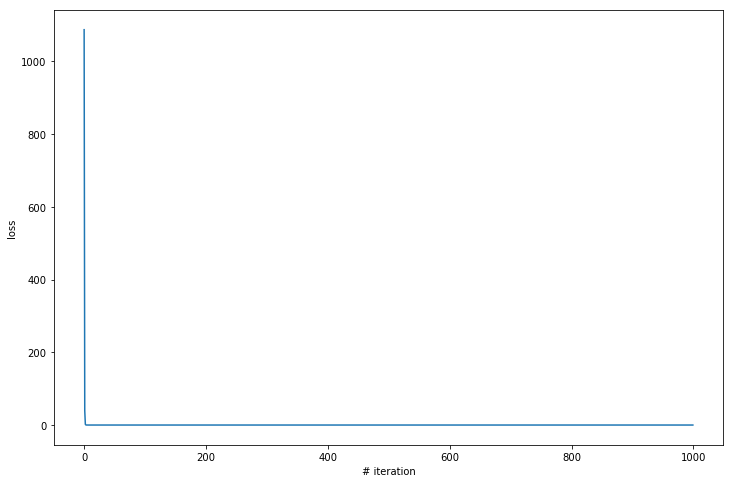

In [11]:
plt.plot(losses)
plt.xlabel('# iteration')
plt.ylabel('loss')

- If "smoothly decrease toward zero" means: "the loss monotonically decreases to zero", then yes, each step the loss is no greater than the previous step.
- If "smoothly" means "slowly" then No. The loss decreases sharply at the first few iterations, then it seems to converges to 5.57999024e-01 and there is no significant reduction anymore.

## Part e

Stochastic gradient descent.  Here you will change your solver to do stochastic gradient descent.  Not much has to change, just your loop from part c.  The Linear and Loss classes stay the same, we just don't show them all the data at the same time.

In [12]:
#Number of steps of gradient descent.  We need more for the stochastic version
reps = 1000
#Learning rate (in practice, often decreases with iteration)
eta = 0.01

#Initialize the pieces of our solver. beta is initialized to a vector of zeros
linear = LinearFunction(p)
loss = Loss()        

#Let's keep track of the loss at each step, so you can visualize your optimization later.  
# We will track two losses: The loss on your single sampled point, and the loss on your whole sample.
losses = np.zeros(reps)
losses_entire = np.zeros(reps)

for i in range(reps):
    #Pick a single observation to show the optimizer this time
    k = np.random.randint(y.shape[0])
    
    #Compute and store your current loss, only for the kth row of X and kth y element!
    #Note: when subsetting X, use X[np.newaxis, k,:].  This keeps the resulting row
    #two dimensional, rather than dropping to a 1d vector.
    losses[i] = loss.forward(
        y[np.newaxis, k,:], 
        linear.forward(X[np.newaxis, k,:]))
    
    #Compute the gradient of loss with respect to beta
    grad = linear.backward().dot(loss.backward())
    
    #Compute losses on the whole sample (you wouldn't usually actually do this, too expensive)
    losses_entire[i] = loss.forward(y, linear.forward(X))
    
    # Adjust beta (using beta_shift) by -grad*eta
    linear.beta_shift(-grad*eta)

In [13]:
linear.beta

array([[2.99817211],
       [0.98839552],
       [4.00615442]])

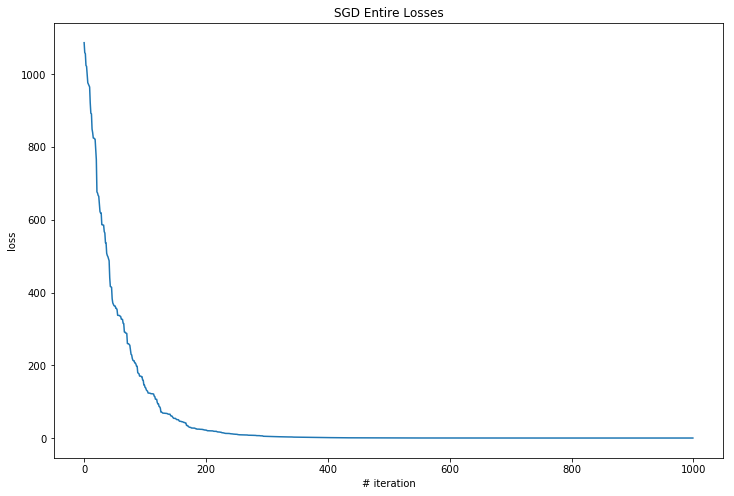

In [14]:
plt.plot(losses_entire, label='entire losses')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.title('SGD Entire Losses')

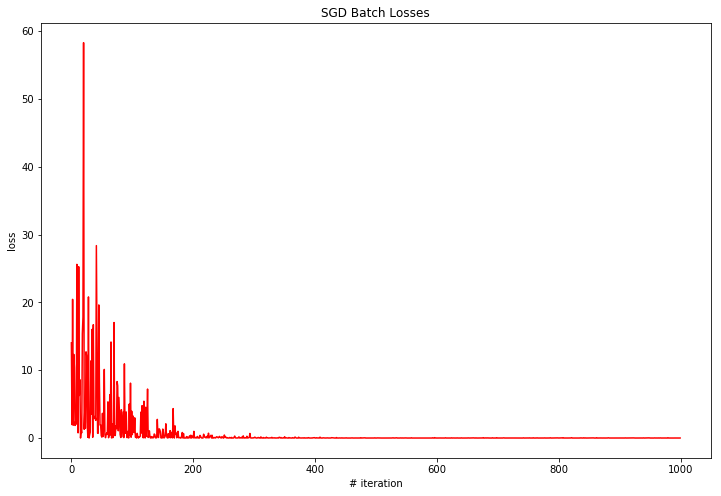

In [15]:
plt.plot(losses, label='batch losses', color='red')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.title('SGD Batch Losses')

- Yes, we still get the correct beta after 1000 iterations.
- However, both the entire losses and the minibatch losses decreases to 0 more slowly and noisily.

# Problem 2

In [16]:
import torch
import torch.autograd
import torch.nn.functional as F

In [17]:
#Same data as before
n = 100
p = 3
beta = np.array([3,1,4]).reshape((-1,1))
np.random.seed(1)
X = scipy.stats.norm.rvs(size=n*p).reshape((n,p))
y = np.dot(X,beta) + scipy.stats.norm.rvs(size=n, scale=0.1).reshape((n,1))

In [18]:
#Convert your data X, y to tensors, using torch.Tensor
## TODO ##
X, y = torch.Tensor(X), torch.Tensor(y)

#Convert those tensors to variables, so that torch will track gradients.  Use torch.autograd.Variable
## TODO ##
X, y = torch.autograd.Variable(X), torch.autograd.Variable(y)

    
#Make a linear function using torch.nn.Linear: http://pytorch.org/docs/master/nn.html#torch.nn.Linear
#Set the bias to False turns off intercept. Not usally desirable, but want to match our problem 1 code.
fc = torch.nn.Linear(3, 1, bias=False)

In [19]:
reps = 100
losses = np.zeros(reps)
for i in range(reps):
    
    # Reset gradients
    fc.zero_grad()

    # Forward pass: Compute the mse_loss between fc(X) and y, using F.mse_loss(guess, truth)
    # Store the output in losses[i]
    # The X and y here should be the Variable versions of the Tensors, created above.
    output = F.mse_loss(fc(X), y) ## TODO ##
    losses[i] = output
    
    # Compute all the gradients
    output.backward()

    # Apply gradients.  In practice, this can be carried out by built in functions
    # as well, like torch.optim.SGD
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad.data)


In [20]:
list(fc.parameters())

[Parameter containing:
 tensor([[ 3.0026,  0.9864,  3.9993]])]

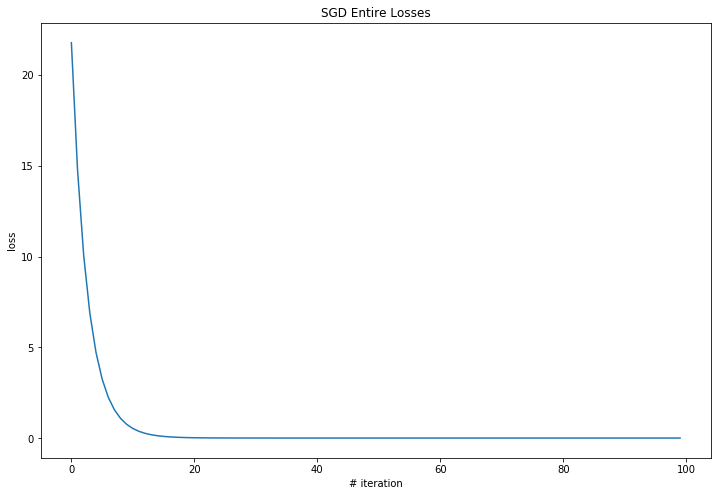

In [21]:
plt.plot(losses, label='entire losses (Torch)')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.title('SGD Entire Losses')

- As shown above, the parameters is again close to $[3, 1, 4]^{\top}$, and the total loss curve matches the one we have seen in 1-c.

# Problem 3

In [99]:
%%capture
#May want to turn this off the first time you run, to see all the output
%run mnist_example.py

## Part(a)

In [33]:
print(test_loader.dataset[6][0].numpy().shape)
print(test_loader.dataset[6][1])

(1, 28, 28)
tensor(4)


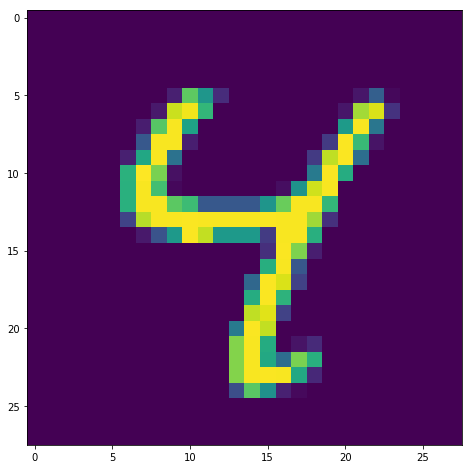

In [30]:
plt.imshow(
    test_loader.dataset[6][0].numpy().reshape(28,28))

- This is a "4".

## Part(b)

In [83]:
single_test_point = Variable(
    test_loader.dataset[6][0].unsqueeze(0))
log_likelihood = model(single_test_point)
prob = np.exp(log_likelihood.detach().numpy())

In [84]:
print(np.argmax(prob))
print(prob[0][np.argmax(prob)])

4
0.99790543


- Yes, the model makes the correct prediction: "4", and it assigns almost all probability on this label.

## Part(c)

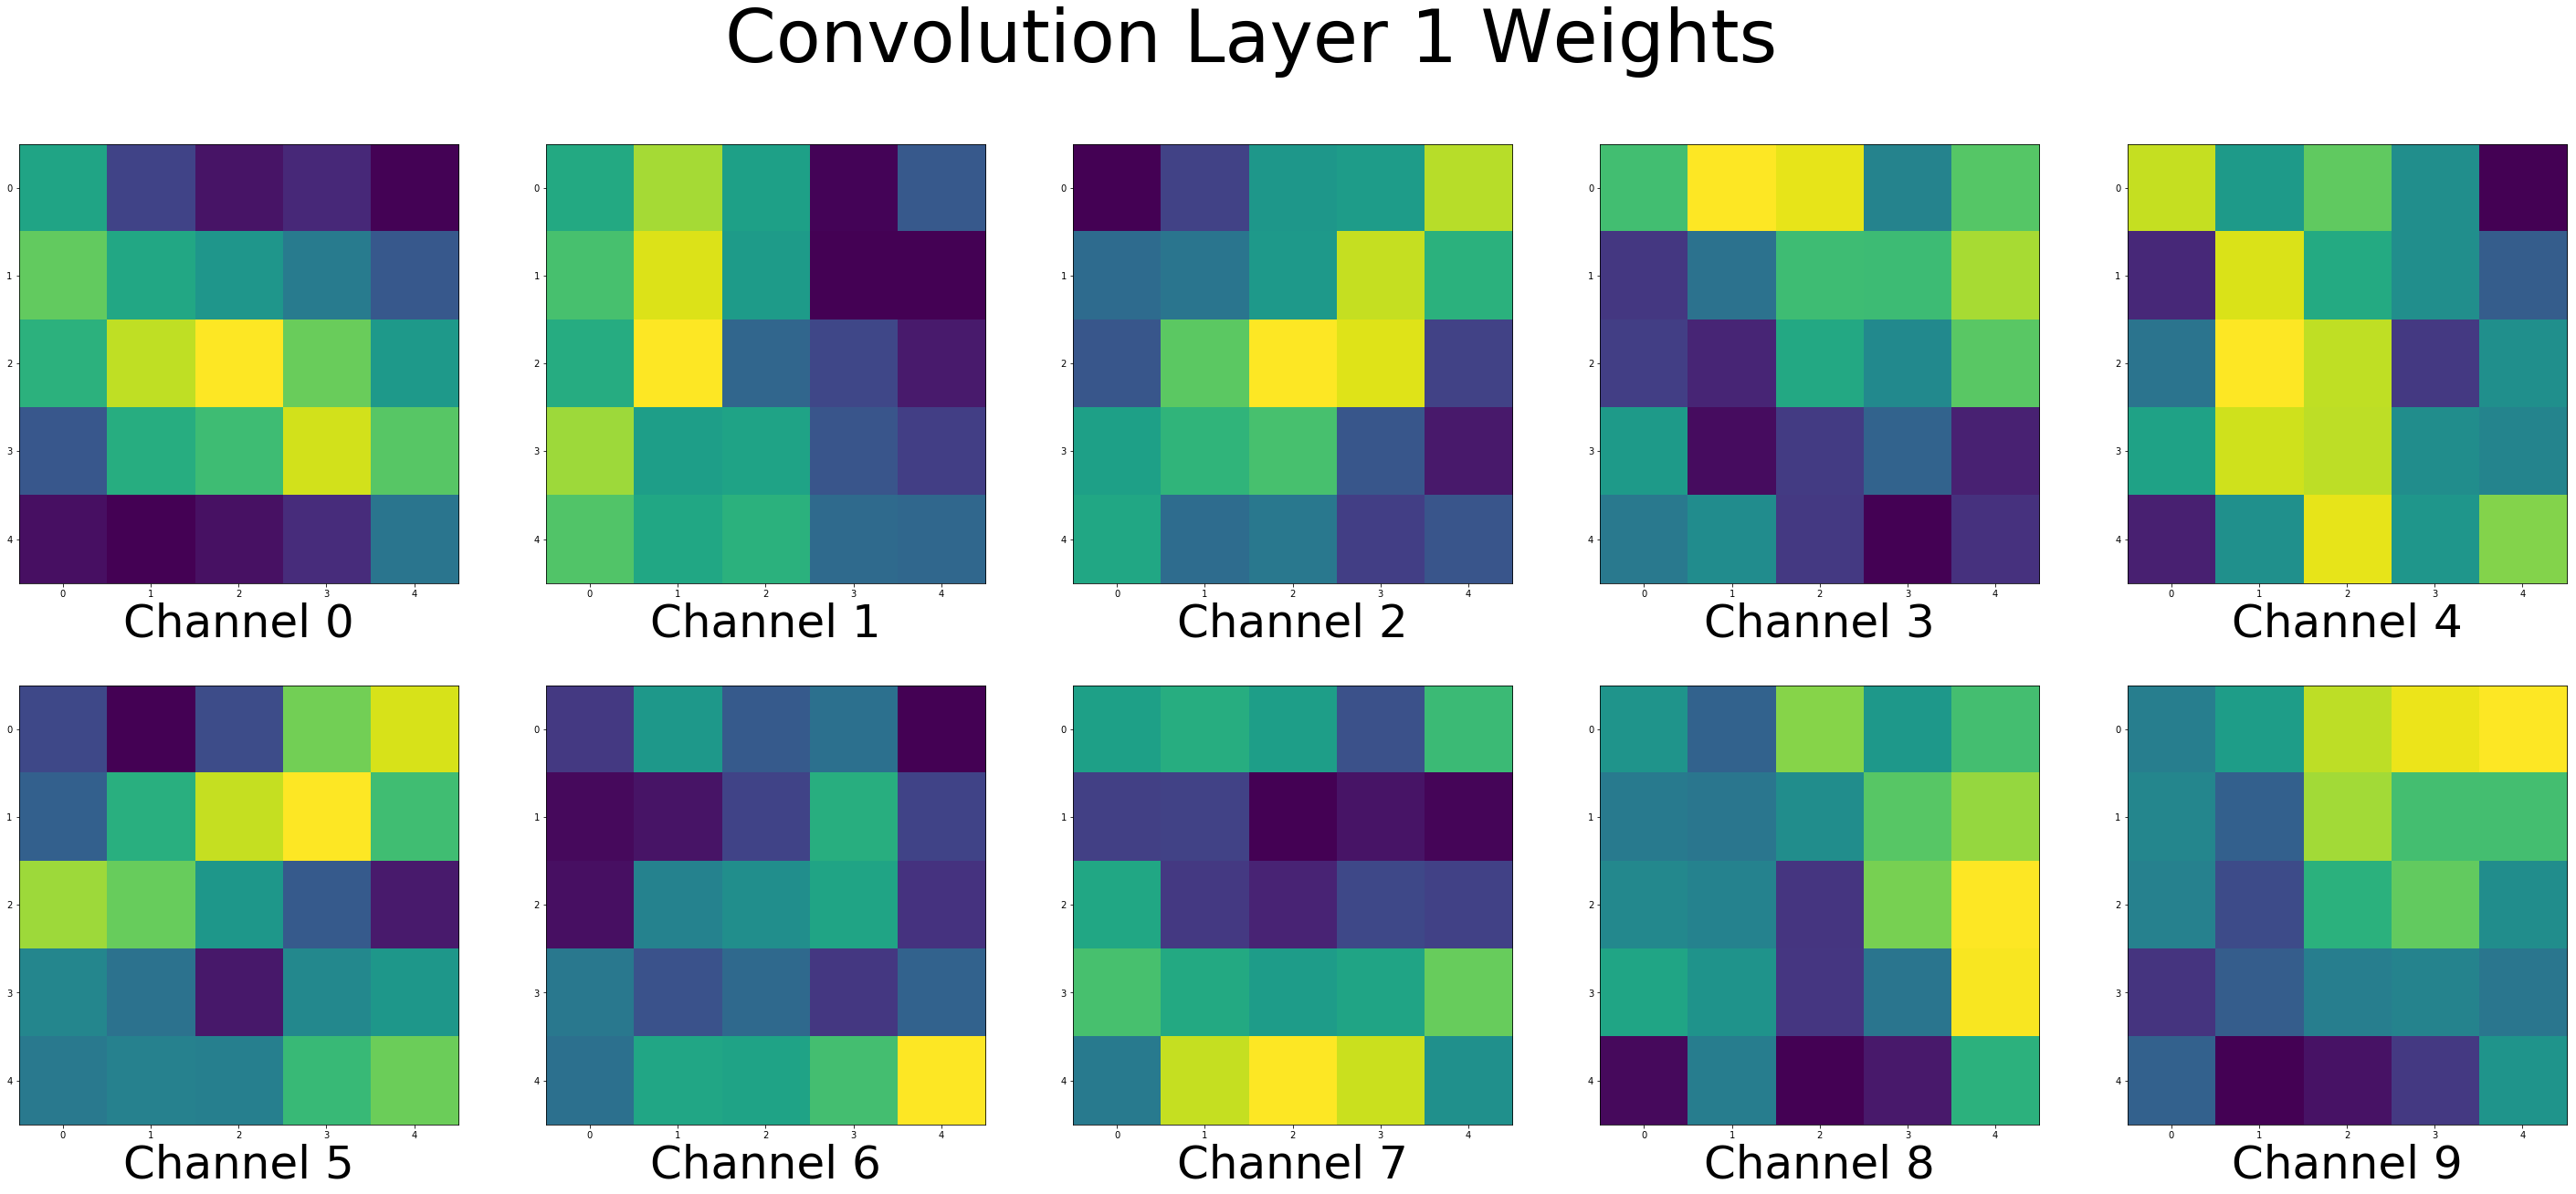

In [97]:
fig, axes = plt.subplots(2, 5, figsize=(50,20))
axes = axes.reshape(10,)
for i in range(10):
    filter_1 = model.conv1.weight[
        i,0,:,:].data.numpy()
    axes[i].imshow(filter_1)
    axes[i].set_xlabel('Channel %d'% (i), fontsize=50)

plt.suptitle('Convolution Layer 1 Weights', fontsize=80)

## Part(d)

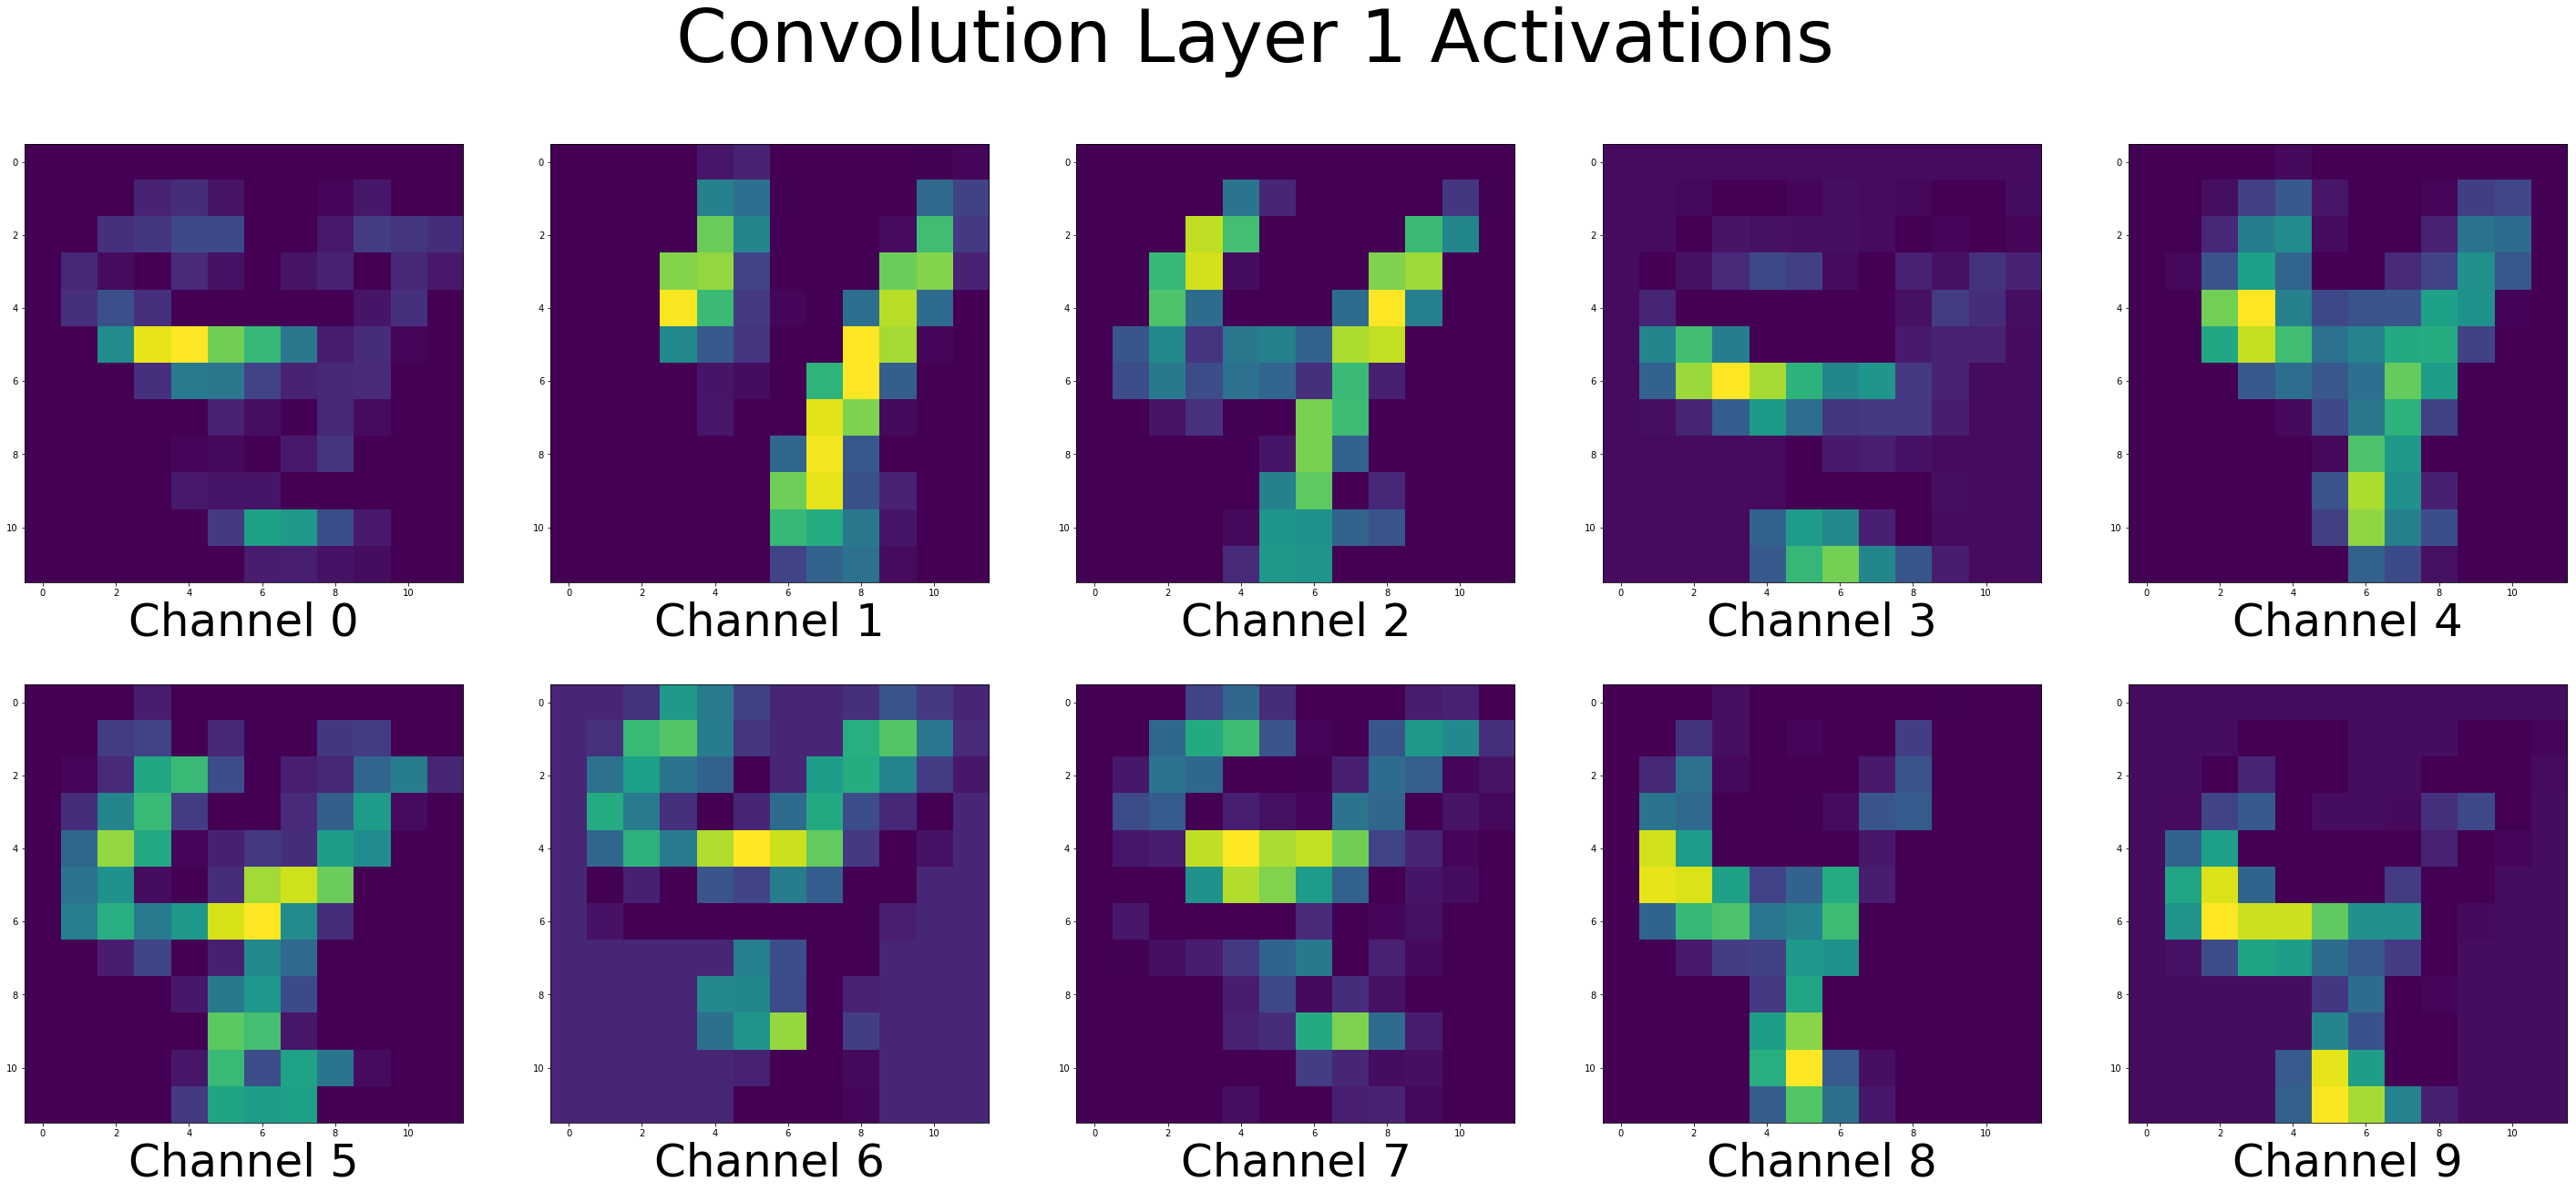

In [98]:
activations_1 = F.relu(F.max_pool2d(
    model.conv1(Variable(single_test_point)),2))[0]

fig, axes = plt.subplots(2, 5, figsize=(50,20))
axes = axes.reshape(10,)
for i in range(10):
    act_1 = activations_1[i].detach().numpy()
    axes[i].imshow(act_1) 
    axes[i].set_xlabel('Channel %d'% (i), fontsize=50)
    
plt.suptitle('Convolution Layer 1 Activations', fontsize=80)

## Part(e)

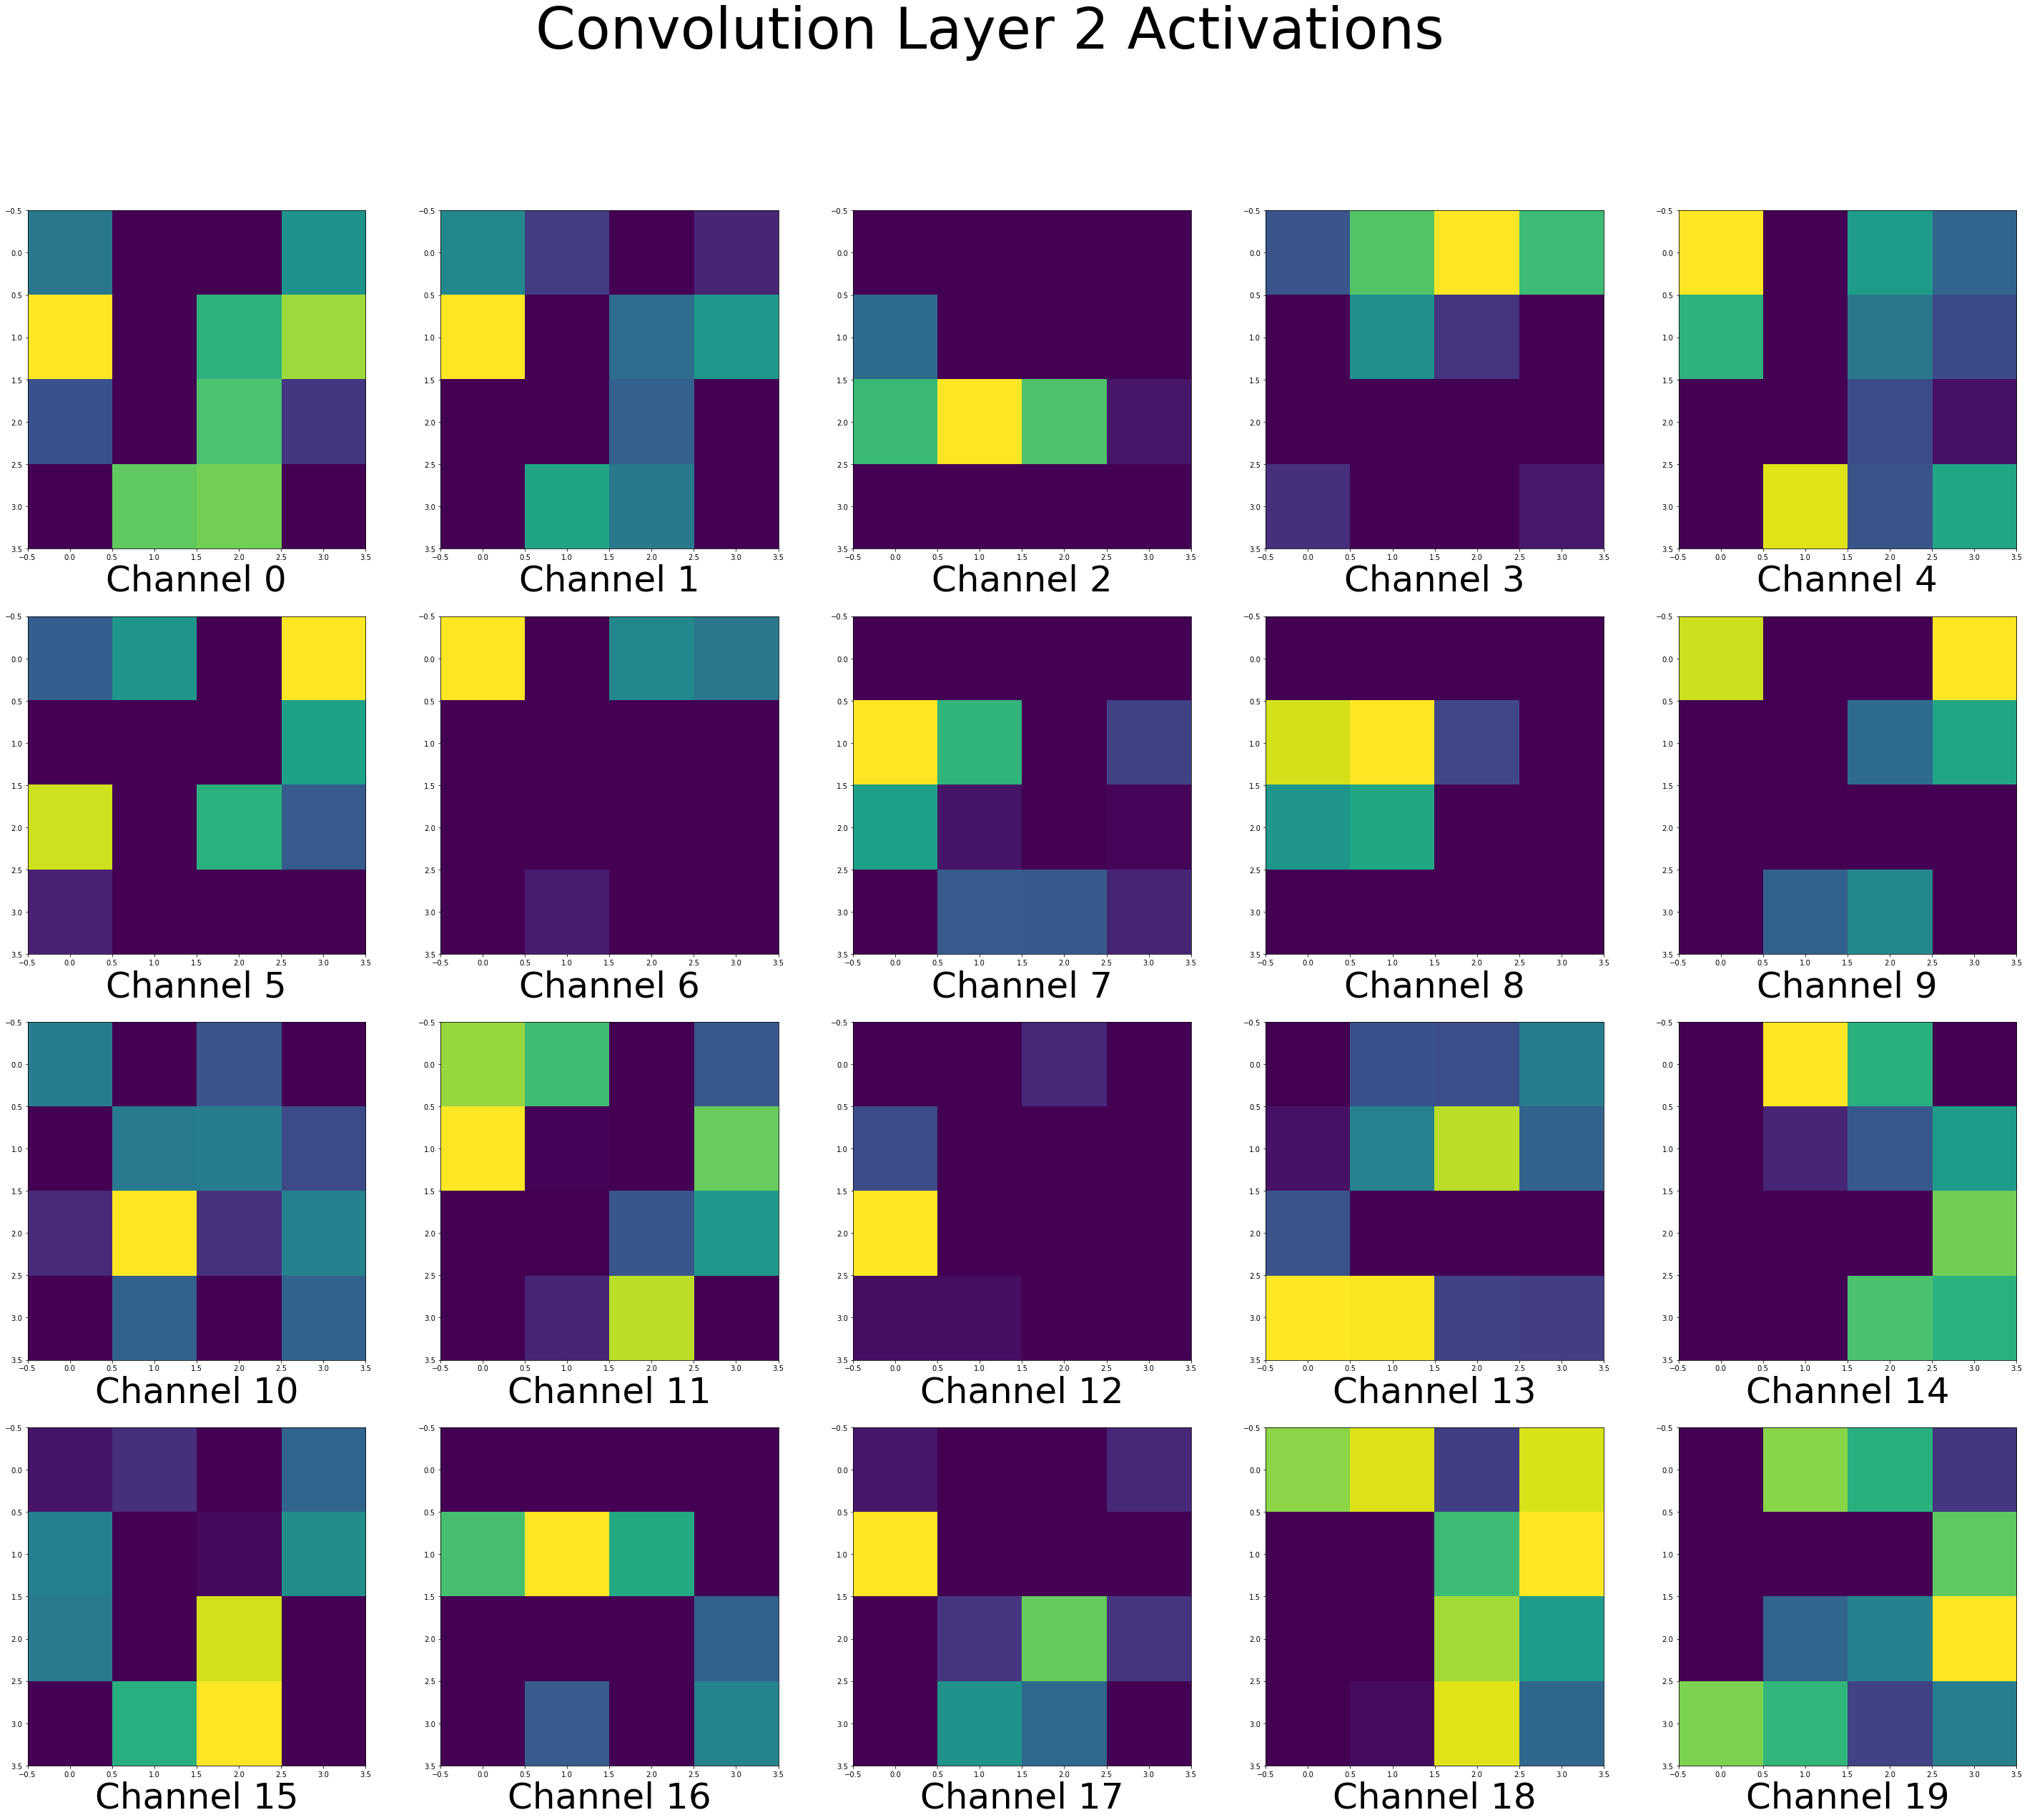

In [96]:
activations_1 = F.relu(F.max_pool2d(
    model.conv1(Variable(single_test_point)),2))
activations_2 = F.relu(F.max_pool2d(
    model.conv2(activations_1), 2))[0]

fig, axes = plt.subplots(4, 5, figsize=(50,40))
axes = axes.reshape(20,)

for i in range(20):
    act_2 = activations_2[i].detach().numpy()
    axes[i].imshow(act_2)
    axes[i].set_xlabel('Channel %d'% (i), fontsize=50)
    
plt.suptitle('Convolution Layer 2 Activations', fontsize=80)